In [1]:
!pip install -U segmentation-models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.0 MB/s eta 0:00:00


In [2]:
import numpy as np 
import pandas as pd
import tensorflow as tf 
import os
import seaborn as sns
import matplotlib.pyplot as plt

from os import listdir
from time import process_time, time
from math import ceil
from PIL import Image
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image


os.environ["SM_FRAMEWORK"] = "tf.keras"

import segmentation_models as sm

2024-02-29 18:06:01.148034: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-29 18:06:01.148134: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-29 18:06:01.282834: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Segmentation Models: using `tf.keras` framework.


In [3]:
def set_seed(seed=1):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed()

In [4]:
data_dir_path = '/kaggle/input/airbus-ship-detection/'

test_dir = data_dir_path + 'test_v2/'
train_dir = data_dir_path + 'train_v2/'

train_segmentation = pd.read_csv(data_dir_path + 'train_ship_segmentations_v2.csv', index_col='ImageId')

COEF_SMALLER_IMG = 2
IMG_H = 768 // COEF_SMALLER_IMG
IMG_W = 768 // COEF_SMALLER_IMG
BATCH_SIZE = 32

In [5]:
# broken_imgs = []

# start_time = time()
# for i, img in enumerate(listdir(train_dir)):
#     if not (img.endswith('.jpg')):
#         print(img, 'not jpg')
#         broken_imgs.append(img)
#     elif os.path.getsize(train_dir + img) < 3000:
#         print(img, 'size less 3000 bytes')
#         broken_imgs.append(img)

#     if i % 10000 == 0:
#         temp = time()
#         print(i, temp - start_time)
#         start_time = temp
        
        
# if len(broken_imgs) == 0:
#     print('There is no broken imgs')
# else:
#     print('There is broken imgs', broken_imgs)

In [6]:
train_segmentation['is_any_ships'] = train_segmentation['EncodedPixels'].isnull().map({True:0, False:1})
train_segmentation['is_any_ships'] 

ImageId
00003e153.jpg    0
0001124c7.jpg    0
000155de5.jpg    1
000194a2d.jpg    1
000194a2d.jpg    1
                ..
fffedbb6b.jpg    0
ffff2aa57.jpg    0
ffff6e525.jpg    0
ffffc50b4.jpg    0
ffffe97f3.jpg    0
Name: is_any_ships, Length: 231723, dtype: int64

In [7]:
count_imgs_with_ships = train_segmentation[train_segmentation['is_any_ships'] == 1].index.nunique()

count_imgs = len(list(train_segmentation.index.unique()))

count_ships = len(train_segmentation[train_segmentation['is_any_ships'] == 1].index)

count_imgs_no_ships = count_imgs - count_imgs_with_ships

In [8]:
stats_cols = ['Images', 'have no ships', 'have ships', 'overall ships']
stats_data = [[count_imgs, count_imgs_no_ships, count_imgs_with_ships, count_ships]]

stats_df = pd.DataFrame(stats_data, columns=stats_cols)
stats_df

,Images,have no ships,have ships,overall ships
0,192556,150000,42556,81723


<Axes: >

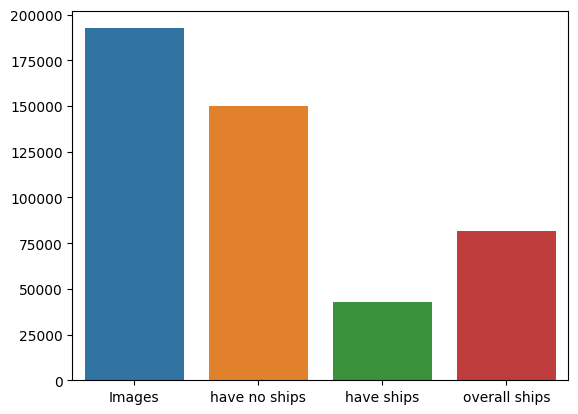

In [9]:
sns.barplot(stats_df)

In [10]:
def drop_values(li: list, cut_part: float):
    for n in range(int(len(li) * cut_part)):
        index = np.random.randint(0, len(li))
        li.pop(index)

        
cut_no_ship_imgs = list(train_segmentation[train_segmentation['is_any_ships'] == 0].index)
cut_part = 0.8

drop_values(cut_no_ship_imgs, cut_part)
    
len(cut_no_ship_imgs)

30000

In [11]:
split_part = 0.2
train_with_ship_imgs = list(train_segmentation[train_segmentation['is_any_ships'] == 1].index.unique())
valid_with_ship_imgs = list(train_with_ship_imgs)

drop_values(train_with_ship_imgs, split_part)
valid_with_ship_imgs = list(set(valid_with_ship_imgs) - set(train_with_ship_imgs))

len(train_with_ship_imgs), len(valid_with_ship_imgs)

(34045, 8511)

In [12]:
train_no_ship_imgs = list(cut_no_ship_imgs)
valid_no_ship_imgs = list(cut_no_ship_imgs)

drop_values(train_no_ship_imgs, split_part)
valid_no_ship_imgs = list(set(valid_no_ship_imgs) - set(train_no_ship_imgs))

len(train_no_ship_imgs), len(valid_no_ship_imgs)

(24000, 6000)

In [13]:
train_imgs = train_with_ship_imgs + train_no_ship_imgs
valid_imgs = valid_with_ship_imgs + valid_no_ship_imgs
np.random.shuffle(train_imgs)
np.random.shuffle(valid_imgs)

In [14]:
def rle_paint_pixels(rle, arr1d):
    rl = rle.split()

    for i in range(len(rl) // 2):
        pixel = int(rl[i * 2])
        length = int(rl[i * 2 + 1])
        arr1d[pixel:pixel+length] = 1
        
    return arr1d


def rle_decode(rle_list, coef_smaller_img=COEF_SMALLER_IMG):    
    if type(rle_list) is float:
        return np.zeros((IMG_H, IMG_H, 1), dtype=np.float32)
    
    arr_for_img = np.zeros((768 * 768), dtype=np.float32)
    
    if type(rle_list) is str:
        rle_paint_pixels(rle_list, arr_for_img)
    else: 
        for rle in rle_list:
            rle_paint_pixels(rle, arr_for_img)
            
    arr_for_img = arr_for_img.reshape((768, 768))
    arr_for_img = arr_for_img.T
    arr_for_img = arr_for_img.reshape((768, 768, 1))    
    arr_for_img = arr_for_img[::coef_smaller_img, ::coef_smaller_img]
    return arr_for_img


def rle_encode(mask_arr1d):
    '''
    Returns run-length encoding
    with ALL ships in the mask
    '''
    
    s = ''
    
    length = 1
    one_pair = False
    for i, pixel in enumerate(mask_arr1d):
        if pixel == 1 and one_pair is False:
            s += str(i) + ' '
            one_pair = True
        elif pixel == 1:
            length += 1
        elif pixel == 0 and one_pair is True:
            s += str(length)  + ' '
            one_pair = False
            length = 1
            
    return s.removesuffix(' ')

(768, 768, 3)
(384, 384, 3)


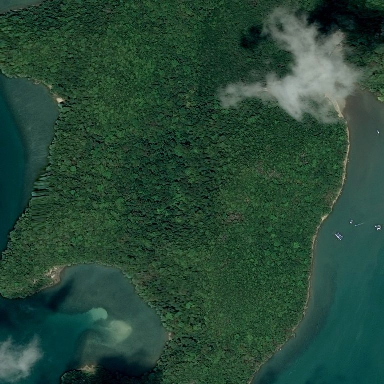

In [15]:
img_test = Image.open(train_dir + '/e6fd0c12e.jpg')
test_arr = image.img_to_array(img_test)

print(test_arr.shape)
test_arr = test_arr[::COEF_SMALLER_IMG, ::COEF_SMALLER_IMG]
print(test_arr.shape)
image.array_to_img(test_arr)

In [16]:
train_segmentation.loc['e6fd0c12e.jpg']['EncodedPixels']

ImageId
e6fd0c12e.jpg    535742 2 536508 4 537274 7 538040 9 538807 8 5...
e6fd0c12e.jpg         518107 1 518874 3 519642 2 520409 1 521176 1
e6fd0c12e.jpg    577030 1 577798 3 578565 6 579333 8 580100 10 ...
e6fd0c12e.jpg    578764 3 579532 3 580299 3 581067 3 581835 3 5...
e6fd0c12e.jpg                           516568 2 517335 2 521172 1
e6fd0c12e.jpg    577223 1 577990 3 578758 1 579526 1 580294 1 5...
e6fd0c12e.jpg    519644 1 520411 2 521177 3 521944 3 522711 3 5...
e6fd0c12e.jpg                  539584 1 540350 3 541116 3 541882 2
e6fd0c12e.jpg         521181 2 521948 3 522714 4 523481 3 524250 1
e6fd0c12e.jpg    575684 3 576452 3 577220 2 577987 3 578755 2 5...
e6fd0c12e.jpg    544963 3 545731 3 546498 4 547266 3 548034 3 5...
e6fd0c12e.jpg    578761 2 579528 3 580296 2 581064 2 581831 3 5...
e6fd0c12e.jpg    522719 2 523485 4 524251 7 525018 7 525787 5 5...
e6fd0c12e.jpg    516570 1 517337 3 518104 3 518872 2 519639 1 5...
e6fd0c12e.jpg    513494 1 514261 4 515029 5 515796 4 5

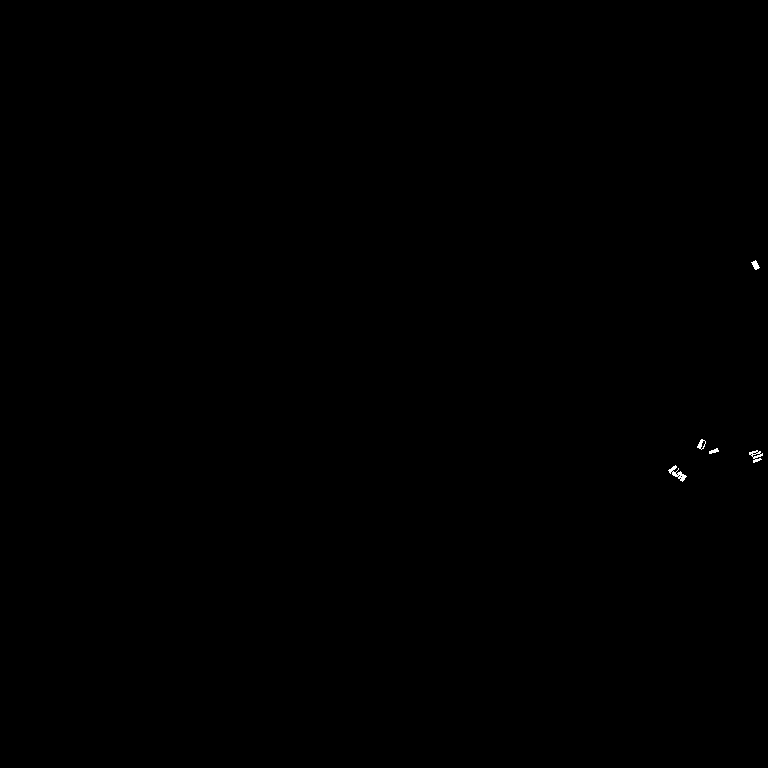

In [17]:
# rle_encode works faster with float64 array than float32 one
test_arr = rle_decode(train_segmentation.loc['e6fd0c12e.jpg']['EncodedPixels'], coef_smaller_img=1).astype(np.float64)

image.array_to_img(test_arr)

In [18]:
# make 1d array for rle encoding
print(test_arr.shape)
test_arr = test_arr.reshape((768, 768)).T
print(test_arr.shape)
test_arr = test_arr.reshape((768 * 768))
print(test_arr.shape)
print(test_arr.dtype, type(test_arr))

rle_encode(test_arr)

(768, 768, 1)
(768, 768)
(589824,)
float64 <class 'numpy.ndarray'>


'513494 1 514261 4 515029 5 515796 4 516563 4 516568 3 517330 4 517335 5 518098 4 518104 4 518865 4 518872 5 519634 2 519639 1 519642 3 520406 1 520409 1 520411 2 521172 2 521176 4 521181 2 521944 3 521948 3 522711 7 522719 2 523480 4 523485 4 524250 8 525018 7 525787 5 526555 3 527324 1 535742 2 536508 4 537274 7 538040 9 538807 8 538817 1 539575 4 539584 1 540344 1 540350 3 541112 1 541116 3 541881 3 544963 3 545731 3 546498 4 547266 3 548034 3 548801 4 549569 4 550336 4 551104 4 551874 2 575684 3 576452 3 577030 1 577220 2 577223 1 577798 3 577987 6 578565 6 578755 2 578758 1 578761 2 578764 3 579333 8 579523 2 579526 1 579528 3 579532 3 580100 10 580291 2 580294 1 580296 2 580299 3 580869 9 581058 2 581061 1 581064 2 581067 3 581639 6 581826 2 581829 1 581831 3 581835 3 582409 4 582596 2 582599 2 582603 2 583179 1 583363 3 583367 2 583370 3 584131 2 584134 3 584138 2 584902 2 584907 1 585669 3'

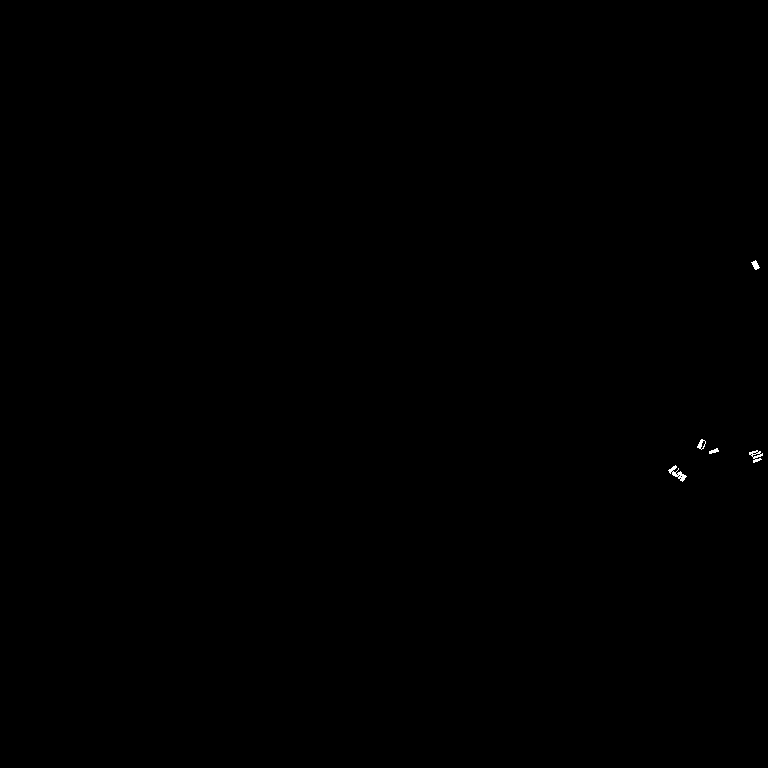

In [19]:
image.array_to_img(rle_decode(rle_encode(test_arr), coef_smaller_img=1))

In [20]:
def make_gen_train_dir_Xy(imgs_list):
    n_batches = len(imgs_list) // BATCH_SIZE
    
    for batch_i in range(n_batches):
        start_batch = batch_i * BATCH_SIZE
        end_batch = batch_i * BATCH_SIZE + BATCH_SIZE
        
        batch_img = np.zeros((BATCH_SIZE, IMG_H, IMG_W, 3), dtype=np.float32)
        batch_target = np.zeros((BATCH_SIZE, IMG_H, IMG_W, 1), dtype=np.float32)
        
        for i, path_img in enumerate(imgs_list[start_batch:end_batch]):
            img = image.img_to_array(Image.open(train_dir + path_img), dtype=np.float32)
            img = img[::COEF_SMALLER_IMG, ::COEF_SMALLER_IMG]
            target = rle_decode(train_segmentation.loc[path_img]['EncodedPixels'])
            
            batch_img[i] = img
            batch_target[i] = target
            
        yield batch_img, batch_target
        

def gen_train():
    return make_gen_train_dir_Xy(train_imgs)
    
def gen_valid():
    return make_gen_train_dir_Xy(valid_imgs)     

In [21]:
train_data = tf.data.Dataset.from_generator(
         gen_train,
         output_signature=(
             tf.TensorSpec(shape=(BATCH_SIZE, IMG_H, IMG_W, 3), dtype=tf.float32),
             tf.TensorSpec(shape=(BATCH_SIZE, IMG_H, IMG_W, 1), dtype=tf.float32)
         )
)

valid_data = tf.data.Dataset.from_generator(
         gen_valid,
         output_signature=(
             tf.TensorSpec(shape=(BATCH_SIZE, IMG_H, IMG_W, 3), dtype=tf.float32),
             tf.TensorSpec(shape=(BATCH_SIZE, IMG_H, IMG_W, 1), dtype=tf.float32)
         )
)

In [22]:
model = sm.Unet(
    backbone_name='resnet18',
    encoder_weights='imagenet',
    activation='sigmoid',
    input_shape=(IMG_H, IMG_W, 3),
)

model.compile(
    'Adam',
    loss=sm.losses.bce_dice_loss,
    metrics=[sm.metrics.iou_score],
)

44920640/44920640 [==============================] - 0s 0us/step


In [23]:
# model.summary()

In [24]:
# model.load_weights('')

model_history = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=20,
    steps_per_epoch=90,
    validation_steps=22,
#     epochs=15,
#     steps_per_epoch=120,
#     validation_steps=30,
)

Epoch 1/18


I0000 00:00:1709229997.141682     109 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


120/120 [==============================] - 124s 743ms/step - loss: 1.0747 - iou_score: 0.0475 - val_loss: 1.1594 - val_iou_score: 0.0143
Epoch 2/18
120/120 [==============================] - 80s 667ms/step - loss: 0.4791 - iou_score: 0.3778 - val_loss: 2.3547 - val_iou_score: 0.0370
Epoch 3/18
120/120 [==============================] - 77s 645ms/step - loss: 0.3668 - iou_score: 0.4876 - val_loss: 0.9501 - val_iou_score: 0.0878
Epoch 4/18
120/120 [==============================] - 76s 638ms/step - loss: 0.3647 - iou_score: 0.4914 - val_loss: 0.3831 - val_iou_score: 0.4718
Epoch 5/18
120/120 [==============================] - 71s 595ms/step - loss: 0.3235 - iou_score: 0.5336 - val_loss: 0.4056 - val_iou_score: 0.4483
Epoch 6/18
120/120 [==============================] - 70s 582ms/step - loss: 0.3081 - iou_score: 0.5535 - val_loss: 0.4086 - val_iou_score: 0.4478
Epoch 7/18
120/120 [==============================] - 71s 595ms/step - loss: 0.2766 - iou_score: 0.5868 - val_loss: 0.3424 - val

In [25]:
model.save_weights('/kaggle/working/')
model.save_weights('/kaggle/working/my_model.weights.h5')

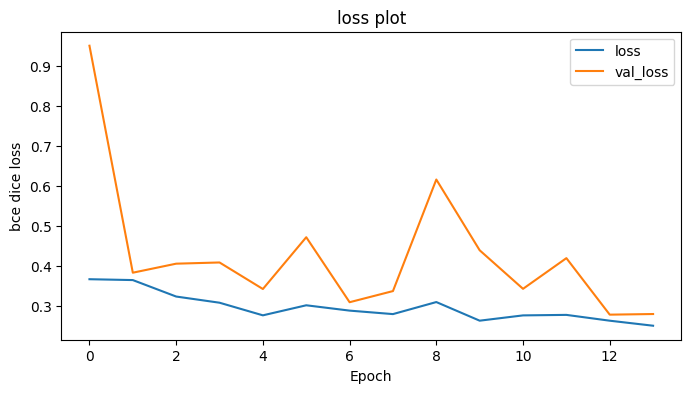

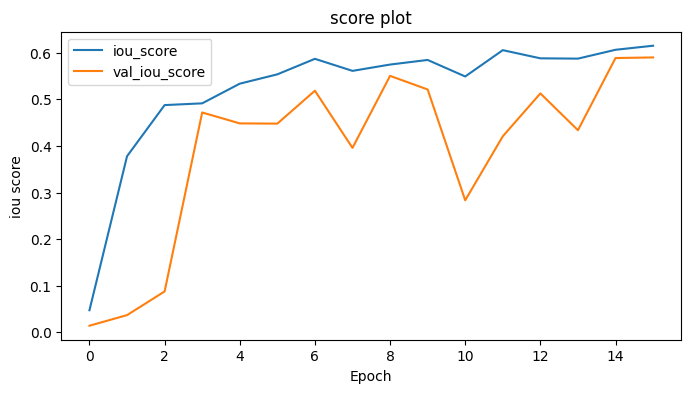

In [30]:
plt.figure(figsize=(8, 4))
plt.plot(model_history.history['loss'][2:], label='loss')
plt.plot(model_history.history['val_loss'][2:], label='val_loss')
plt.title('loss plot'); 
plt.xlabel('Epoch');
plt.ylabel('bce dice loss');
plt.legend()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(model_history.history['iou_score'], label='iou_score')
plt.plot(model_history.history['val_iou_score'], label='val_iou_score')
plt.title('score plot'); 
plt.xlabel('Epoch');
plt.ylabel('iou score');
plt.legend()
plt.show()

In [61]:
test_imgs = listdir(test_dir)
EMPTY_IMG = np.zeros((IMG_H, IMG_W, 1), dtype=np.float64)


def make_gen_test():
    n_batches = ceil(len(test_imgs) / BATCH_SIZE)
    
    for batch_i in range(n_batches):
        start_batch = batch_i * BATCH_SIZE
        end_batch = batch_i * BATCH_SIZE + BATCH_SIZE
        
        batch_img = np.zeros((BATCH_SIZE, IMG_H, IMG_W, 3), dtype=np.float64)
        
        for i, path_img in enumerate(test_imgs[start_batch:end_batch]):
            img = image.img_to_array(Image.open(test_dir + path_img), dtype=np.float64)
            img = img[::COEF_SMALLER_IMG, ::COEF_SMALLER_IMG]
            batch_img[i] = img

        yield batch_img
        

test_data = tf.data.Dataset.from_generator(
         make_gen_test,
         output_signature=(tf.TensorSpec(shape=(BATCH_SIZE, IMG_H, IMG_W, 3), dtype=tf.float64))
)

In [62]:
df_preds = pd.DataFrame(columns=['ImageId', 'EncodedPixels'])

# rle_encode works faster with float64 array than float32 one
for i_batch, X in enumerate(test_data):
    prediction_batch = model.predict_on_batch(X)
    
    for i_img, img_arr in enumerate(prediction_batch):  
        img_arr = np.round(img_arr).astype(np.float64)
        img_name = test_imgs[(i_batch-1)*BATCH_SIZE+i_img]
        
        if (EMPTY_IMG == img_arr).all():
            df_preds.loc[len(df_preds)] = {'ImageId':img_name, 'EncodedPixels':np.nan}
            continue
        
        img_arr = img_arr.repeat(2, axis=0).repeat(2, axis=1)
        img_arr = img_arr.reshape((768, 768)).T.reshape((768*768))
        rle = rle_encode(img_arr)
        
        df_preds.loc[len(df_preds)] = {'ImageId':img_name, 'EncodedPixels':rle}

In [63]:
df_preds

,ImageId,EncodedPixels
0,3de89fbce.jpg,NaN
1,30de558c5.jpg,190918 6 191686 6 192450 14 193218 14 193984 1...
2,1242ef543.jpg,NaN
3,5a1bd2dc6.jpg,NaN
4,18609713e.jpg,NaN
...,...,...
15611,15421557a.jpg,NaN
15612,ac9e20ec9.jpg,NaN
15613,a755458f2.jpg,NaN
15614,8a8540ba2.jpg,NaN


In [65]:
if len(df_preds) > len(test_imgs): 
    to_drop = len(df_preds) - len(test_imgs)
    df_preds.drop(df_preds.tail(to_drop).index, inplace=True)

In [66]:
df_preds

,ImageId,EncodedPixels
0,3de89fbce.jpg,NaN
1,30de558c5.jpg,190918 6 191686 6 192450 14 193218 14 193984 1...
2,1242ef543.jpg,NaN
3,5a1bd2dc6.jpg,NaN
4,18609713e.jpg,NaN
...,...,...
15601,2a5188b05.jpg,NaN
15602,c13fa69b3.jpg,NaN
15603,7879b0080.jpg,430826 10 431594 10 432360 14 433128 14 433892...
15604,10d72c6e3.jpg,120166 8 120934 8 121702 10 122470 10 123238 1...


In [67]:
df_preds.to_csv('submission.csv', index=False)